# Linear Regression in statsmodels (Practice)

**Task:** Run a linear regression with statsmodels predict the price of a car.

**Data:** https://www.kaggle.com/datasets/hellbuoy/car-price-prediction

**Steps to perform:**

- Perform initial preprocessing of data
- Perform preprocessing for statsmodels
- Run the model in statsmodels and produce a results summary
- Evaluate the model on the test set
- In a markdown cell below your results, summarize what assumptions the model did and/or did not meet
- If you model did not meet the assumptions, then iterate on the model and add/change any preprocessing needed to improve its performance

# 1. Preliminary Steps

In [52]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score, mean_squared_error
np.random.seed(321)
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
plt.rcParams['figure.facecolor'] = 'white'
plt.style.use(['seaborn-talk'])

C:\Users\yang0108\AppData\Local\Temp\ipykernel_8792\2356783839.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-talk'])


In [53]:
# load data
df = pd.read_csv('Data/CarPrice_Assignment.csv')

# check
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


**Target:** The model we build will be used to predict the price of the cars.

In [54]:
# check for null values
df.isna().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [55]:
# renaming categorical variable 'symboling' according to data dictionary
symboling_map = {-3: "safest",
                -2: "safer",
                -1: "safe",
                0: "neutral",
                1: "risky",
                2: "riskier",
                3: "riskiest"}

df['symboling'] = df['symboling'].replace(symboling_map)

# check
df['symboling'].value_counts()

neutral     67
risky       54
riskier     32
riskiest    27
safe        22
safer        3
Name: symboling, dtype: int64

# 2. Model Assumptions (Part 1)

## 2.1 Assumption of Linearity

The linear regression model assumes that the features in the model have a linear relationship with the target.

In [56]:
# select numeric columns
num_selector = make_column_selector(dtype_include = 'number')
cols = num_selector(df.drop(columns = ['price', 'car_ID']))
len(cols)

13

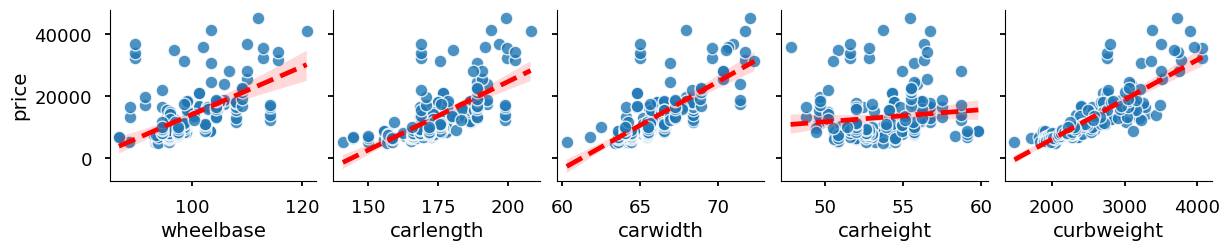

In [57]:
# look at first 5 numeric features
sns.pairplot(df, y_vars='price',kind='reg',x_vars=cols[:5],
             plot_kws=dict(line_kws={'color':'red', 'ls':'--'},
                           scatter_kws={'edgecolor':'white','lw':1}));

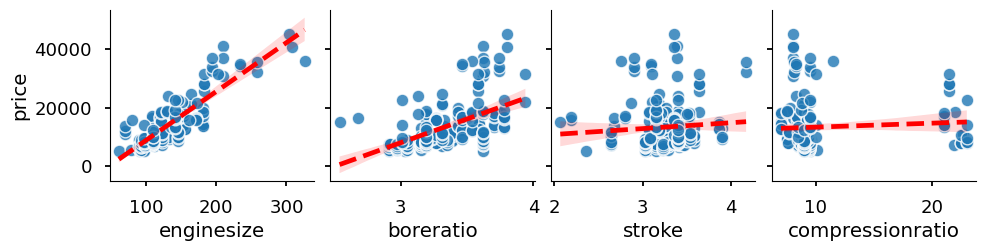

In [58]:
# look at next 4
sns.pairplot(df, y_vars='price',kind='reg',x_vars=cols[5:9],
             plot_kws=dict(line_kws={'color':'red', 'ls':'--'},
                           scatter_kws={'edgecolor':'white','lw':1}));

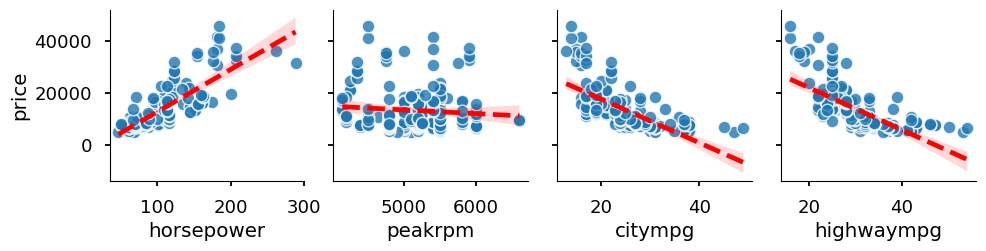

In [59]:
# look at last 4
sns.pairplot(df, y_vars='price',kind='reg',x_vars=cols[9:13],
             plot_kws=dict(line_kws={'color':'red', 'ls':'--'},
                           scatter_kws={'edgecolor':'white','lw':1}));

**Note:** Should consider dropping features that have a large "pink" area on the line of best fit (indicates the model is not sure of the linear relationship).

The features that do not have a clear collinearity with the target are:
- 'carheight'
- 'stroke'
- 'compressionratio'
- 'peakrpm'

We will remove these from the dataset so our data can meet the assumption of linearity.

In [60]:
# drop nonlinear features
df = df.drop(columns = ['carheight', 
                        'stroke', 
                        'compressionratio', 
                        'peakrpm'])

## 2.2 Assumption of Little-to-No Multicollinearity

The linear regression model assumes that no features are correlated with each other. Of a pair of features that correlate, the feature with the least amount of a linear relationship with the target should be removed from the data.

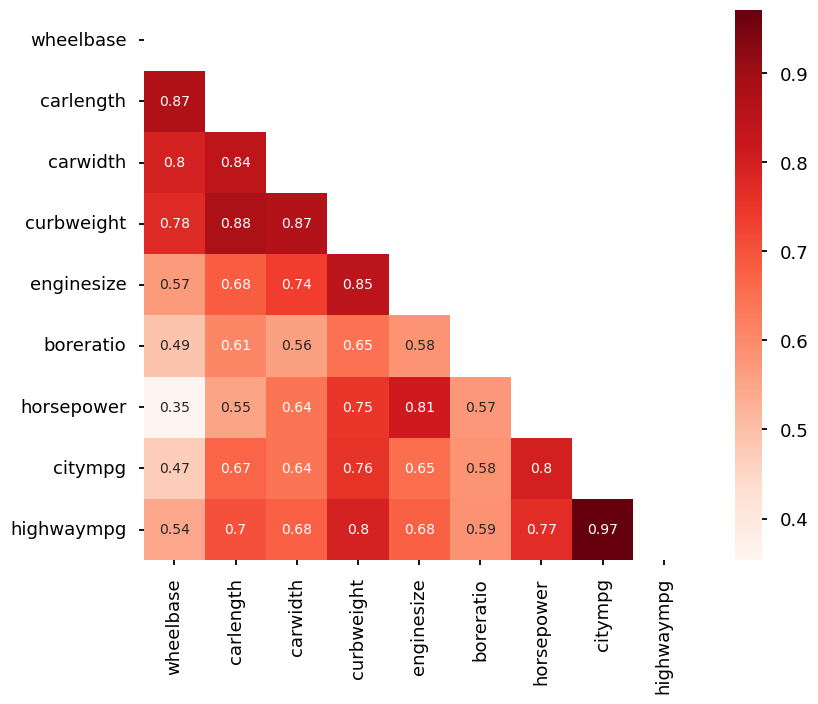

In [61]:
# calculate correlations
corr = df.drop(columns = ['price', 'car_ID']).corr(numeric_only = True).abs()

# mask for easier viewing
mask = np.triu(np.ones_like(corr))

# plot
sns.heatmap(corr, 
            square = True, 
            cmap = 'Reds', 
            annot = True, 
            mask = mask);

Correlations between features above 0.8, sorted from highest to lowest collinearity:
1. 'citympg' and 'highwaympg' (0.97)
2. 'curbweight' and 'carlength' (0.88)
3. 'carlength' and 'wheelbase' (0.87)
4. 'curbweight' and 'carwidth' (0.87)
5. 'enginesize' and 'curbweight' (0.85)
6. 'carwidth' and 'carlength' (0.84)
7. 'horsepower' and 'enginesize' (0.81)

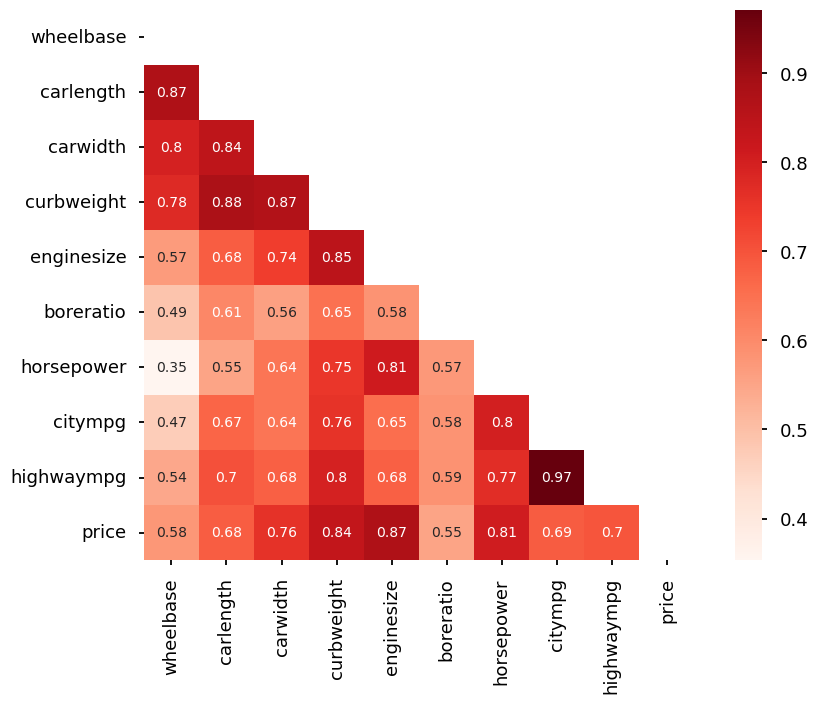

In [62]:
# add target to correlation heatmap to determine which feature
# in each pair can be dropped
corr = df.drop(columns = ['car_ID']).corr(numeric_only = True).abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr,
            square = True, 
            cmap = 'Reds', 
            annot = True, 
            mask = mask);

Correlations between features above 0.8 (ones in **bold** will be dropped), with their coefficient of linearity with the target (listed from highest to lowest collinearity):
1. **'citympg' (0.69)** and 'highwaympg' (0.7)
2. **'curbweight' (0.84)** and **'carlength' (0.68)**
3. **'carlength'** and 'wheelbase'
4. **'curbweight' (0.84)** and **'carwidth' (0.76)**
5. 'enginesize' (0.87) and **'curbweight' (0.84)**
6. **'carwidth'** and **'carlength'** 
7. **'horsepower' (0.81)** and 'enginesize' (0.87)

The features we will drop are:
- 'citympg'
- 'curbweight'
- 'carlength'
- 'carwidth'
- 'horsepower'


Question: What to do when the variable kept from one pair is the one to be dropped from another pair?

Answer: Start with the HIGHEST collinearity pair (in our correlation heatmap above, that would be 'highwaympg' and 'citympg'). Get rid of the feature with the weakest correlation to the target. Then, if the feature you got rid of appears in another pair, keep the other feature in the pair.

In [63]:
# drop columns showing high correlation with other columns,
# lower correlation with target
df = df.drop(columns = ['citympg', 'curbweight', 'carlength',
                       'carwidth', 'horsepower'])

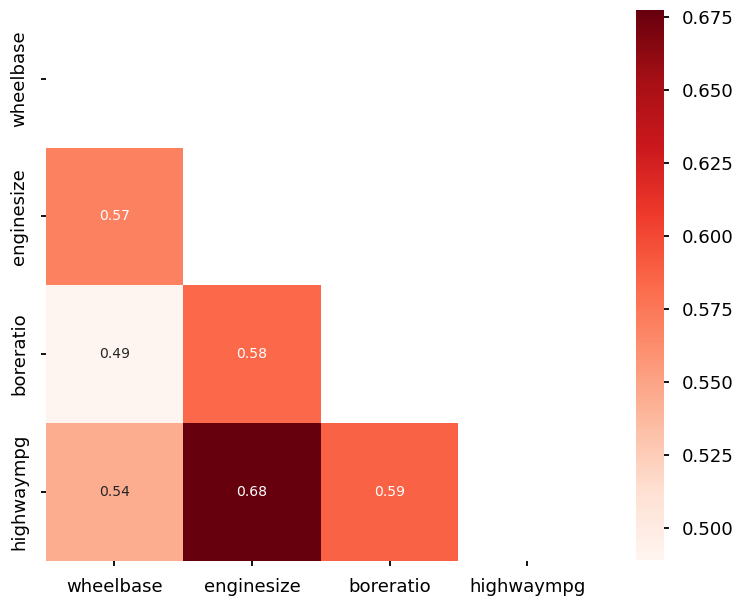

In [65]:
## check
corr = df.drop(columns = ['price', 'car_ID']).corr(numeric_only = True).abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, 
            square = True, 
            cmap = 'Reds', 
            annot = True, 
            mask = mask);

There are no remaining correlations above 0.8. We have met the assumption of Little-to-No Collinearity and can move on.

# 3. Initial Preprocessing

In [14]:
# make X and y
y = df['price'].copy()

# for X, will drop 'car_ID' since it is unique to each observation
# will also drop 'CarName'
X = df.drop(columns = ['price', 'car_ID', 'CarName']).copy()

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

# check
X_train.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,horsepower,citympg,highwaympg
17,neutral,gas,std,four,sedan,rwd,front,110.0,197.0,70.9,3505,ohc,six,209,mpfi,3.62,182,15,20
39,neutral,gas,std,four,sedan,fwd,front,96.5,175.4,65.2,2304,ohc,four,110,1bbl,3.15,86,27,33
40,neutral,gas,std,four,sedan,fwd,front,96.5,175.4,62.5,2372,ohc,four,110,1bbl,3.15,86,27,33
47,neutral,gas,std,four,sedan,rwd,front,113.0,199.6,69.6,4066,dohc,six,258,mpfi,3.63,176,15,19
123,safe,gas,std,four,wagon,fwd,front,103.3,174.6,64.6,2535,ohc,four,122,2bbl,3.35,88,24,30


In [15]:
# select categorical columns
cat_select = make_column_selector(dtype_include = 'object')
cat_cols = cat_select(X_train)
cat_cols

['symboling',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem']

In [16]:
# select numerical columns
num_select = make_column_selector(dtype_include = 'number')
num_cols = num_select(X_train)
num_cols

['wheelbase',
 'carlength',
 'carwidth',
 'curbweight',
 'enginesize',
 'boreratio',
 'horsepower',
 'citympg',
 'highwaympg']

In [17]:
# make categorical pipeline
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', 
                                       sparse=False))

# make numeric pipeline (DON'T SCALE)
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

# make preprocessor (column transformer)
preprocessor = make_column_transformer((cat_pipe,cat_cols),
                                        (num_pipe, num_cols), 
                                       remainder='passthrough')

In [18]:
# fit column transformer on training data ONLY
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['symboling', 'fueltype', 'aspiration',
                                  'doornumber', 'carbody', 'drivewheel',
                                  'enginelocation', 'enginetype',
                                  'cylindernumber', 'fuelsystem']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['wheelbase', 'carlength', 'carwidth',
                                  'curbweight', 'enginesize', 'boreratio',
                                  'horsepower', 'citympg', 'highwaympg'])])

In [19]:
# see transformed X_train as a df
pd.DataFrame(preprocessor.transform(X_train).round(3))

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,110.0,197.0,70.9,3505.0,209.0,3.62,182.0,15.0,20.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,96.5,175.4,65.2,2304.0,110.0,3.15,86.0,27.0,33.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,96.5,175.4,62.5,2372.0,110.0,3.15,86.0,27.0,33.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,113.0,199.6,69.6,4066.0,258.0,3.63,176.0,15.0,19.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,103.3,174.6,64.6,2535.0,122.0,3.35,88.0,24.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,109.1,188.8,68.9,2952.0,141.0,3.78,114.0,23.0,28.0
149,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,96.5,175.4,65.2,2465.0,110.0,3.15,101.0,24.0,28.0
150,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,86.6,144.6,63.9,1819.0,92.0,2.91,76.0,31.0,38.0
151,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,95.9,173.2,66.3,2818.0,156.0,3.59,145.0,19.0,24.0


The column names have been lost, so we will get those back.

In [20]:
# create empty list for column names
final_features = []

In [21]:
# categorical column names: in the categorical pipeline
# ('pipeline-1' since we put it first in our preprocessor),
# access the onehotencoder step
ohe_step = preprocessor.named_transformers_['pipeline-1'].named_steps['onehotencoder']

In [22]:
# get feature names out for categorical columns
cat_features = ohe_step.get_feature_names_out(cat_cols)

# check
cat_features

array(['symboling_neutral', 'symboling_riskier', 'symboling_riskiest',
       'symboling_risky', 'symboling_safe', 'symboling_safer',
       'fueltype_diesel', 'fueltype_gas', 'aspiration_std',
       'aspiration_turbo', 'doornumber_four', 'doornumber_two',
       'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd',
       'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front',
       'enginetype_dohc', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_eight', 'cylindernumber_five',
       'cylindernumber_four', 'cylindernumber_six',
       'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two', 'fuelsystem_1bbl', 'fuelsystem_2bbl',
       'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi'],
      dtype=object)

In [23]:
# add categorical column names to final_features
final_features.extend(cat_features)

# check
final_features

['symboling_neutral',
 'symboling_riskier',
 'symboling_riskiest',
 'symboling_risky',
 'symboling_safe',
 'symboling_safer',
 'fueltype_diesel',
 'fueltype_gas',
 'aspiration_std',
 'aspiration_turbo',
 'doornumber_four',
 'doornumber_two',
 'carbody_convertible',
 'carbody_hardtop',
 'carbody_hatchback',
 'carbody_sedan',
 'carbody_wagon',
 'drivewheel_4wd',
 'drivewheel_fwd',
 'drivewheel_rwd',
 'enginelocation_front',
 'enginetype_dohc',
 'enginetype_dohcv',
 'enginetype_l',
 'enginetype_ohc',
 'enginetype_ohcf',
 'enginetype_ohcv',
 'enginetype_rotor',
 'cylindernumber_eight',
 'cylindernumber_five',
 'cylindernumber_four',
 'cylindernumber_six',
 'cylindernumber_three',
 'cylindernumber_twelve',
 'cylindernumber_two',
 'fuelsystem_1bbl',
 'fuelsystem_2bbl',
 'fuelsystem_4bbl',
 'fuelsystem_idi',
 'fuelsystem_mfi',
 'fuelsystem_mpfi',
 'fuelsystem_spdi',
 'fuelsystem_spfi']

In [24]:
# add list of numeric features to final_features
final_features.extend(num_cols)

# check
final_features

['symboling_neutral',
 'symboling_riskier',
 'symboling_riskiest',
 'symboling_risky',
 'symboling_safe',
 'symboling_safer',
 'fueltype_diesel',
 'fueltype_gas',
 'aspiration_std',
 'aspiration_turbo',
 'doornumber_four',
 'doornumber_two',
 'carbody_convertible',
 'carbody_hardtop',
 'carbody_hatchback',
 'carbody_sedan',
 'carbody_wagon',
 'drivewheel_4wd',
 'drivewheel_fwd',
 'drivewheel_rwd',
 'enginelocation_front',
 'enginetype_dohc',
 'enginetype_dohcv',
 'enginetype_l',
 'enginetype_ohc',
 'enginetype_ohcf',
 'enginetype_ohcv',
 'enginetype_rotor',
 'cylindernumber_eight',
 'cylindernumber_five',
 'cylindernumber_four',
 'cylindernumber_six',
 'cylindernumber_three',
 'cylindernumber_twelve',
 'cylindernumber_two',
 'fuelsystem_1bbl',
 'fuelsystem_2bbl',
 'fuelsystem_4bbl',
 'fuelsystem_idi',
 'fuelsystem_mfi',
 'fuelsystem_mpfi',
 'fuelsystem_spdi',
 'fuelsystem_spfi',
 'wheelbase',
 'carlength',
 'carwidth',
 'curbweight',
 'enginesize',
 'boreratio',
 'horsepower',
 'citymp

In [25]:
# transform X_train again, this time with final_features
# as column names; keep X_train.index as index
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns = final_features,
                         index = X_train.index)

# check
X_train_df.head()

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,fuelsystem_spfi,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg
17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,110.0,197.0,70.9,3505.0,209.0,3.62,182.0,15.0,20.0
39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,96.5,175.4,65.2,2304.0,110.0,3.15,86.0,27.0,33.0
40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,96.5,175.4,62.5,2372.0,110.0,3.15,86.0,27.0,33.0
47,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,113.0,199.6,69.6,4066.0,258.0,3.63,176.0,15.0,19.0
123,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,103.3,174.6,64.6,2535.0,122.0,3.35,88.0,24.0,30.0


In [26]:
# transform X_test
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        columns = final_features,
                        index = X_test.index)

# check
X_test_df.head()

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,fuelsystem_spfi,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg
48,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,113.0,199.6,69.6,4066.0,258.0,3.63,176.0,15.0,19.0
196,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,104.3,188.8,67.2,2935.0,141.0,3.78,114.0,24.0,28.0
148,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,96.9,173.6,65.4,2420.0,108.0,3.62,82.0,23.0,29.0
53,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,93.1,166.8,64.2,1945.0,91.0,3.03,68.0,31.0,38.0
99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,97.2,173.4,65.2,2324.0,120.0,3.33,97.0,27.0,34.0


# 4. Preprocessing for statsmodels

In [27]:
# add constant column for statsmodels
# confirm expected results before overwriting variables
# prepend = False puts constant column at end of df
sm.add_constant(X_train_df, prepend=False, has_constant='add').head()

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,const
17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,110.0,197.0,70.9,3505.0,209.0,3.62,182.0,15.0,20.0,1.0
39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,96.5,175.4,65.2,2304.0,110.0,3.15,86.0,27.0,33.0,1.0
40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,96.5,175.4,62.5,2372.0,110.0,3.15,86.0,27.0,33.0,1.0
47,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,113.0,199.6,69.6,4066.0,258.0,3.63,176.0,15.0,19.0,1.0
123,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,103.3,174.6,64.6,2535.0,122.0,3.35,88.0,24.0,30.0,1.0


In [28]:
# overwrite X_train and X_test
X_train_df = sm.add_constant(X_train_df, 
                             has_constant = 'add', 
                             prepend = False)
X_test_df = sm.add_constant(X_test_df, 
                            has_constant = 'add',
                            prepend = False)

# check
display(X_train_df.head(2), X_test_df.head(2))

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,const
17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,110.0,197.0,70.9,3505.0,209.0,3.62,182.0,15.0,20.0,1.0
39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,96.5,175.4,65.2,2304.0,110.0,3.15,86.0,27.0,33.0,1.0


,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,const
48,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,113.0,199.6,69.6,4066.0,258.0,3.63,176.0,15.0,19.0,1.0
196,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,104.3,188.8,67.2,2935.0,141.0,3.78,114.0,24.0,28.0,1.0


# 5. statsmodels Model with Result Summary

In [29]:
# instantiate sm.OLS model with training data
# y goes first, then X
# hasconst = Ture is default; showing for practice
model = sm.OLS(y_train, X_train_df, hasconst = True)

In [30]:
# fit and save result in variable
result = model.fit()

In [31]:
# see model performance metrics (on training data)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     31.15
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           1.19e-44
Time:                        18:26:11   Log-Likelihood:                -1394.9
No. Observations:                 153   AIC:                             2872.
Df Residuals:                     112   BIC:                             2996.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
symboling_neutral      -641.2778    785.655     -0.816      0.416   -2197.953     915.397
symboling_riskier     -1475.7158    857.875     -1.720      0.088   -3175.485     224.053
symboling_riskiest    -1373.5211   1141.931     -1.203      0.232   -3636.110     889.068
symboling_risky        -779.6574    867.829     -0.898      0.371   -2499.149     939.834
symboling_safe        -2839.0257   1154.169     -2.460      0.015   -5125.863    -552.188
symboling_safer       -5021.8537   1847.057     -2.719      0.008   -8681.561   -1362.146
fueltype_diesel       -3755.4421   1548.326     -2.425      0.017   -6823.251    -687.633
fueltype_gas          -8375.6093   2279.757     -3.674      0.000   -1.29e+04   -3858.564
aspiration_std        -6411.6479   1921.072     -3.338      0.001   -1.02e+04   -2605.290
aspiration_turbo      -5719.4035   1923.388     -2.974      0.004   -9530.349   -1908.458
doornumber_four       -6419.2052   1964.065     -3.268      0.001   -1.03e+04   -2527.662
doornumber_two        -5711.8462   1822.844     -3.133      0.002   -9323.577   -2100.115
carbody_convertible    1052.3547   1655.620      0.636      0.526   -2228.044    4332.754
carbody_hardtop       -3244.7159   1448.225     -2.240      0.027   -6114.189    -375.243
carbody_hatchback     -3857.3857   1064.615     -3.623      0.000   -5966.784   -1747.987
carbody_sedan         -2264.5665   1049.341     -2.158      0.033   -4343.702    -185.431
carbody_wagon         -3816.7380   1179.876     -3.235      0.002   -6154.512   -1478.964
drivewheel_4wd        -4608.1176   1425.186     -3.233      0.002   -7431.940   -1784.295
drivewheel_fwd        -4553.2631   1457.989     -3.123      0.002   -7442.081   -1664.445
drivewheel_rwd        -2969.6708   1515.025     -1.960      0.052   -5971.499      32.157
enginelocation_front  -1.213e+04   3695.915     -3.282      0.001   -1.95e+04   -4808.070
enginetype_dohc         584.6516   1363.796      0.429      0.669   -2117.535    3286.839
enginetype_dohcv      -1.339e+04   4753.388     -2.816      0.006   -2.28e+04   -3966.835
enginetype_l          -1823.3136   2242.591     -0.813      0.418   -6266.719    2620.092
enginetype_ohc         3776.0356   1342.925      2.812      0.006    1115.201    6436.870
enginetype_ohcf        3067.0862   1720.781      1.782      0.077    -342.422    6476.594
enginetype_ohcv       -3166.3002   1405.020     -2.254      0.026   -5950.167    -382.433
enginetype_rotor      -1184.1479   1644.543     -0.720      0.473   -4442.600    2074.304
cylindernumber_eight   6720.2397   2748.923      2.445      0.016    1273.602    1.22e+04
cylindernumber_five   -6978.4140   1978.161     -3.528      0.001   -1.09e+04   -3058.941
cylindernumber_four   -8114.2729   1988.562     -4.080      0.000   -1.21e+04   -4174.192
cylindernumber_six    -

# 6. Evaluate Model on Test Data

In [32]:
# use result variable to predict target for test data
test_preds = result.predict(X_test_df)

In [33]:
# evaluate test metrics
print(f'Test R2: {r2_score(y_test, test_preds):.5f}')
print(f'Test MSE: {mean_squared_error(y_test, test_preds):.5f}')

Test R2: 0.94927
Test MSE: 3880674.51118


# 7. Model Assumptions (Part 2)

**Assumption of Normality:** The linear regression model assumes that the residuals (differences between predictions and actual values) is normally distributed.

**Assumption of Homoscedasticity:** The linear model assumes that the residuals have approximately equal variance across the full range of predictions.

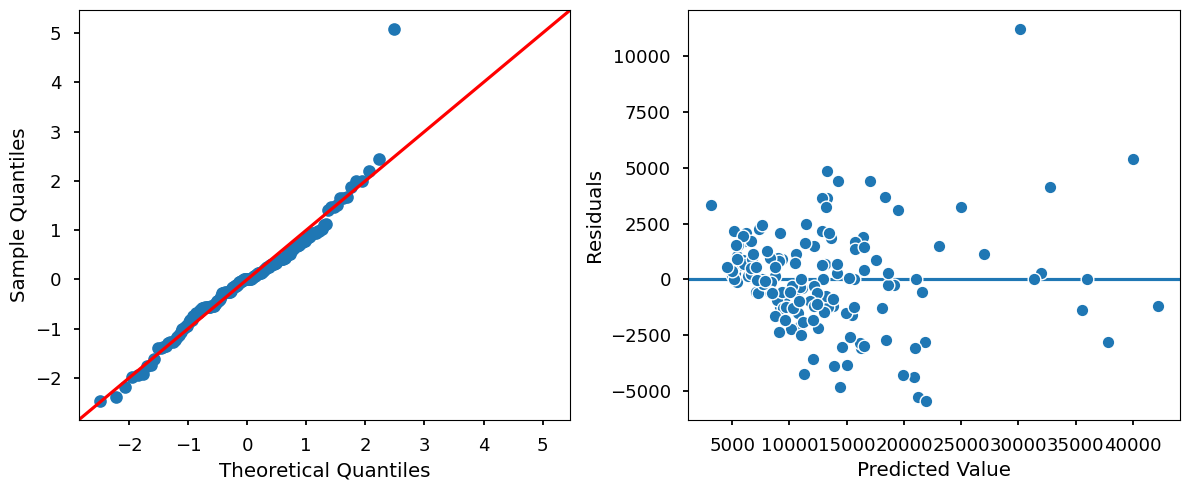

In [34]:
# define helper function to plot qqplot and residual plot
# code from Coding Dojo Learn Platform
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    
evaluate_ols(result,X_train_df, y_train)

The Q-Q Plot shows that our residuals generally follow the assumption of normality, except especially for one observation (on the very right of the plot). This is an outlier that we will take out of the data.

The residual plot shows that our residuals are fairly equally spread out across all predicted values. There is one clear outlier, which will be taken out of the data.

# 8. Iterating on the Model

## 8.1 Remove Outliers

Here we will identify and drop outliers to improve our model.

In [35]:
# instantiate scaler to calculate z-scores
scaler = StandardScaler()
z_price = scaler.fit_transform(y_train.values.reshape(-1, 1))

# check
z_price

array([[ 3.10591049],
       [-0.54747299],
       [-0.35851611],
       [ 2.50255164],
       [-0.53756904],
       [ 0.69039003],
       [-0.97399427],
       [-0.7228771 ],
       [-0.86909063],
       [-0.30599913],
       [-0.82804137],
       [-1.02312306],
       [ 0.10605718],
       [-0.23432583],
       [-0.74946137],
       [-0.59256201],
       [ 0.76545152],
       [ 0.7817409 ],
       [-0.39852284],
       [-0.39761064],
       [ 0.69755736],
       [ 1.16916766],
       [ 0.02004922],
       [ 0.72635699],
       [-0.0543607 ],
       [-0.49091624],
       [-0.97399427],
       [-0.31942159],
       [-0.45716463],
       [-0.70854244],
       [ 0.50547292],
       [ 0.18802537],
       [-0.40217167],
       [-0.85462565],
       [-0.35200036],
       [-0.66319279],
       [-0.11417532],
       [ 0.6651089 ],
       [ 2.75458101],
       [ 0.04806696],
       [-0.53405054],
       [-0.40230198],
       [ 0.38467083],
       [-0.62657425],
       [ 0.17629701],
       [-1

In [36]:
# save outliers with indices
z_price = pd.Series(z_price.flatten(), index = y_train.index)

# check
z_price

17     3.105910
39    -0.547473
40    -0.358516
47     2.502552
123   -0.537569
         ...   
200    0.495048
41    -0.013181
31    -0.806800
124   -0.036768
26    -0.708542
Length: 153, dtype: float64

In [37]:
# create boolean mask for outliers
# outliers defined as more than 3 std from mean
idx_outliers = z_price > 3

# check
idx_outliers

17      True
39     False
40     False
47     False
123    False
       ...  
200    False
41     False
31     False
124    False
26     False
Length: 153, dtype: bool

In [38]:
# how many outliers? (out of 205 observations)
idx_outliers.sum()

4

In [39]:
# save a clean version of y_train and X_train with outliers removed
y_train_cln = y_train[~idx_outliers]
X_train_cln = X_train_df[~idx_outliers]

In [40]:
# calculate range of prices of cars now in our dataframe
# this gives our stakeholders an expectation of the types
# of cars our model can predict prices for
print(f"Our model includes cars priced:")
print(f"- Greater than ${y_train_cln.min():,.2f}")
print(f"- Less than ${y_train_cln.max():,.2f}")

Our model includes cars priced:
- Greater than $5,118.00
- Less than $36,000.00


In [41]:
# remove outliers from test data
z_price_test = scaler.transform(y_test.values.reshape(-1, 1))
z_price_test = pd.Series(z_price_test.flatten(), index = y_test.index )
idx_outliers_test = z_price_test > 3

In [42]:
# how many outliers in test data?
idx_outliers_test.sum()

1

In [43]:
# make clean version of X_test and y_test
X_test_cln = X_test_df[~idx_outliers_test] 
y_test_cln = y_test[~idx_outliers_test]

In [44]:
X_train_cln

,symboling_neutral,symboling_riskier,symboling_riskiest,symboling_risky,symboling_safe,symboling_safer,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,citympg,highwaympg,const
39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,96.5,175.4,65.2,2304.0,110.0,3.15,86.0,27.0,33.0,1.0
40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,96.5,175.4,62.5,2372.0,110.0,3.15,86.0,27.0,33.0,1.0
47,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,113.0,199.6,69.6,4066.0,258.0,3.63,176.0,15.0,19.0,1.0
123,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,103.3,174.6,64.6,2535.0,122.0,3.35,88.0,24.0,30.0,1.0
66,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,104.9,175.0,66.1,2700.0,134.0,3.43,72.0,31.0,39.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,109.1,188.8,68.9,2952.0,141.0,3.78,114.0,23.0,28.0,1.0
41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,96.5,175.4,65.2,2465.0,110.0,3.15,101.0,24.0,28.0,1.0
31,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,86.6,144.6,63.9,1819.0,92.0,2.91,76.0,31.0,38.0,1.0
124,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,95.9,173.2,66.3,2818.0,156.0,3.59,145.0,19.0,24.0,1.0


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     33.49
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           5.04e-45
Time:                        18:26:16   Log-Likelihood:                -1319.2
No. Observations:                 149   AIC:                             2720.
Df Residuals:                     108   BIC:                             2844.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
symboling_neutral      -984.18

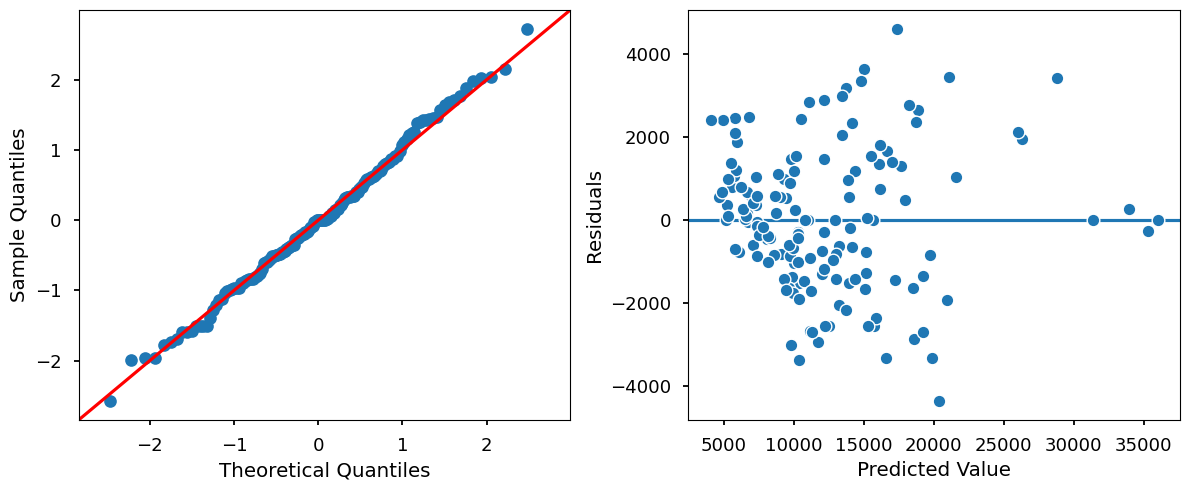

In [45]:
# look at new model with outliers removed
model = sm.OLS(y_train_cln, X_train_cln)
result = model.fit()
print(result.summary())
evaluate_ols(result, X_train_cln, y_train_cln)

This Q-Q Plot and Residual Plot look better than previously.

## 8.2 Remove Columns with Insignificant P-Values

In [46]:
# save p-values
p_vals = result.pvalues

# filter for p-values that are > 0.05
p_vals[p_vals > 0.05]

symboling_neutral       0.113768
symboling_riskier       0.094115
symboling_riskiest      0.718795
symboling_risky         0.190971
carbody_convertible     0.728744
carbody_sedan           0.081722
drivewheel_rwd          0.222523
enginetype_dohc         0.618050
enginetype_dohcv        0.663783
enginetype_ohc          0.272765
enginetype_ohcf         0.787760
enginetype_ohcv         0.194384
cylindernumber_eight    0.068310
cylindernumber_three    0.500691
fuelsystem_1bbl         0.249632
fuelsystem_2bbl         0.980673
fuelsystem_4bbl         0.265368
fuelsystem_mfi          0.352154
fuelsystem_mpfi         0.498576
fuelsystem_spdi         0.070201
fuelsystem_spfi         0.282705
enginesize              0.561692
boreratio               0.557371
horsepower              0.644639
citympg                 0.205446
highwaympg              0.231862
dtype: float64

In [51]:
# check the value counts of categorical variables
print("symboling:\n", df['symboling'].value_counts())
print("carbody:\n", df['carbody'].value_counts())
print("drivewheel:\n", df['drivewheel'].value_counts())
print("enginetype:\n", df['enginetype'].value_counts())
print("cylindernumber:\n", df['cylindernumber'].value_counts())
print("fuelsystem:\n", df['fuelsystem'].value_counts())

symboling:
 neutral     67
risky       54
riskier     32
riskiest    27
safe        22
safer        3
Name: symboling, dtype: int64
carbody:
 sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: carbody, dtype: int64
drivewheel:
 fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64
enginetype:
 ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: enginetype, dtype: int64
cylindernumber:
 four      159
six        24
five       11
eight       5
two         4
three       1
twelve      1
Name: cylindernumber, dtype: int64
fuelsystem:
 mpfi    94
2bbl    66
idi     20
1bbl    11
spdi     9
4bbl     3
mfi      1
spfi     1
Name: fuelsystem, dtype: int64


In [ ]:
# alternate way to see how many values are in a categorical
# column:
category_cols = [col for col in X_train_df.columns if col.startswith('category')]

# confirm by printing first few values
category_cols[:3]

# get number of values for that category
len(category_cols)

# how many of those values are insignificant?
len(p_vals[p_vals > 0.05].startswith('category'))

symboling: Since there are 6 symboling values and 4 of them have insignificant p-values, we will get rid of the symboling feature.

carbody: Two out of five car body types were insignificant, so we will keep this feature.

drivewheel: 1 out of 3 were insignificant; we will keep this.

enginetype: 5 out of 7 were insignificant; we will drop this.

cylindernumber: 2 out of 7 were insignificant; we will keep this.

fuelsystem: 7 out of 8 were insignificant; we will drop this.